<a href="https://colab.research.google.com/github/changeden/289A-Unsupervised-Learning/blob/main/LithoDiffusion_MemoryAnalysis_Contact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LithoDiffusion with Shape-Focused Training & Memory Analysis

This notebook includes:
1. Training a DDPM model on MetalSet dataset with deeper U-Net, L1 loss, and no entropy regularization (5 epochs).
2. Generating samples using the trained model.
3. SSIM & Entropy-based memorization analysis.

In [ ]:
# Install dependencies
!pip install diffusers accelerate transformers einops scikit-image --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00


In [ ]:
import torch, os, zipfile, shutil
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.models import AutoencoderKL
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray
from skimage.transform import resize

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('✅ Using device:', device)

✅ Using device: cuda


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip MetalSet ZIP files
with zipfile.ZipFile('/content/drive/MyDrive/Litho_dataset/Contact/target.zip','r') as z:
    z.extractall('/content/target')
with zipfile.ZipFile('/content/drive/MyDrive/Litho_dataset/Contact/printed.zip','r') as z:
    z.extractall('/content/printed')

In [ ]:
# Prepare data folders and copy images
!mkdir -p /content/data/target /content/data/printed
!cp /content/target/target/*.png /content/data/target/
!cp /content/printed/printed/*.png /content/data/printed/

In [ ]:
# Load dataset
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
dataset = ImageFolder(root='/content/data', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
print('✅ Dataset loaded:', len(dataset), 'images')

✅ Dataset loaded: 326 images


In [ ]:
# Load VQ-VAE & deeper UNet
vqvae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-mse').to(device).eval()
model = UNet2DModel(
    sample_size=32,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(256, 256, 512, 512),
    down_block_types=('DownBlock2D','AttnDownBlock2D','AttnDownBlock2D','AttnDownBlock2D'),
    up_block_types=('AttnUpBlock2D','AttnUpBlock2D','AttnUpBlock2D','UpBlock2D')
).to(device)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn.functional as F

# 1) 二值化前先 collapse channels → single‐channel mask
def to_binary_mask(x, thresh=0.5):
    """
    x: Tensor, shape [B,C,H,W] or [B,1,H,W] or [B,H,W]
    返回: Tensor [B,H,W], 0/1 binary mask
    """
    # 如果有 channel 維，就平均到單通道
    if x.ndim == 4:
        x = x.mean(dim=1)    # [B,H,W]
    # 如果還有 channel=1 維度
    if x.ndim == 3 and x.shape[1] == 1:
        x = x.squeeze(1)
    # Threshold
    return (x > thresh).float()  # [B,H,W]


# 2) Chamfer Distance with robust shape handling
def chamfer_distance(a_bin, b_bin):
    """
    a_bin, b_bin: Tensor [B,H,W] binary masks
    回傳 batch 平均 Chamfer 距離
    """
    B, H, W = a_bin.shape
    total_cd = 0.0

    # 預先建立像素座標網格 (H×W×2)
    coords = torch.stack(torch.meshgrid(
        torch.arange(H, device=a_bin.device),
        torch.arange(W, device=a_bin.device),
    ), dim=-1).float()  # [H,W,2]

    for i in range(B):
        pa = (a_bin[i] > 0.5).nonzero(as_tuple=False).float()  # [Na,2]
        pb = (b_bin[i] > 0.5).nonzero(as_tuple=False).float()  # [Nb,2]
        if pa.numel()==0 or pb.numel()==0:
            continue
        # Pairwise L2
        d = torch.cdist(pa, pb, p=2)  # [Na,Nb]
        cd = d.min(dim=1)[0].mean() + d.min(dim=0)[0].mean()
        total_cd += cd

    return total_cd / B


# 3) 在訓練迴路中呼叫
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
epochs = 10

for epoch in range(epochs):
    running = 0.0
    for images, _ in dataloader:
        images = images.to(device)  # [B,3,128,128] 或 [B,1,128,128]

        # 編碼 → noising → U-Net predict（略）
        with torch.no_grad():
            latents = vqvae.encode(images).latent_dist.mode()
        noise = torch.randn_like(latents)
        ts = torch.randint(0, 1000, (latents.size(0),), device=device).long()
        noisy = noise_scheduler.add_noise(latents, noise, ts)
        pred_noise = model(noisy, ts).sample

        # ① latent MSE
        loss_mse = F.mse_loss(pred_noise, noise)

        # ② L1 reconstruction
        sigma = noise_scheduler.init_noise_sigma
        lat_approx = (noisy - pred_noise * sigma).detach()
        recon_cont = vqvae.decode(lat_approx).sample  # [B,3,128,128]
        loss_l1 = F.l1_loss(recon_cont, images)

        # ③ Chamfer on binary masks
        recon_bin  = to_binary_mask(recon_cont)  # [B,128,128]
        target_bin = to_binary_mask(images)
        loss_cd    = chamfer_distance(recon_bin, target_bin)

        # combine losses (可調整權重)
        loss = loss_mse + 0.5 * loss_l1 + 0.2 * loss_cd

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

    print(f"Epoch {epoch+1}/{epochs} — Avg Loss: {running/len(dataloader):.4f}")

print("✅ Training finished.")


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/10 — Avg Loss: 1.1264
Epoch 2/10 — Avg Loss: 0.6122
Epoch 3/10 — Avg Loss: 0.6013
Epoch 4/10 — Avg Loss: 0.5917
Epoch 5/10 — Avg Loss: 0.5653
Epoch 6/10 — Avg Loss: 0.5674
Epoch 7/10 — Avg Loss: 0.5150
Epoch 8/10 — Avg Loss: 0.6207
Epoch 9/10 — Avg Loss: 0.4514
Epoch 10/10 — Avg Loss: 0.5955
✅ Training finished.


In [ ]:
# Generate samples (5 images)
generated_images = []
for _ in range(20):
    latents = torch.randn((1, 4, 32, 32)).to(device)
    for t in reversed(range(1000)):
        timestep = torch.tensor([t], device=device).long()
        with torch.no_grad():
            noise_pred = model(latents, timestep).sample
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
    with torch.no_grad():
        recon = vqvae.decode(latents).sample
    img = recon.squeeze().cpu().clamp(0,1).numpy()
    generated_images.append(img)
print(f"✅ Generated {len(generated_images)} images.")

✅ Generated 20 images.


In [ ]:
# Load and preprocess printed training images (128x128)
import glob
from PIL import Image
preprocess = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
printed_paths = glob.glob('/content/data/printed/*.png')
train_images = []
for p in printed_paths:
    img = Image.open(p)
    t = preprocess(img)
    train_images.append(t.squeeze(0).numpy())
print(f"✅ Loaded {len(train_images)} training images.")

✅ Loaded 163 training images.


In [ ]:
# Define preprocess + memory analysis (SSIM + Entropy)
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray
from skimage.transform import resize

def preprocess_image(img, shape=(128,128)):
    if img.ndim == 3:
        img = np.transpose(img, (1,2,0))
        img = rgb2gray(img)
    return resize(img, shape, anti_aliasing=True)

ssim_scores, entropies, matches = [], [], []
for gen in generated_images:
    g = preprocess_image(gen)
    best_ssim, best_match = 0.0, None
    for tr in train_images:
        t = tr if tr.shape == g.shape else resize(tr, g.shape, anti_aliasing=True)
        sc = ssim(g, t, data_range=1.0)
        if sc > best_ssim:
            best_ssim, best_match = sc, t
    ssim_scores.append(best_ssim)
    matches.append(best_match)
    h, _ = np.histogram(g, bins=256, range=(0,1), density=False)
    p = h / np.sum(h)  # Normalize to get proper PMF
    entropies.append(-np.sum(p * np.log2(p + 1e-10)))
labels = ['memorized' if s > 0.98 else 'novel' for s in ssim_scores]

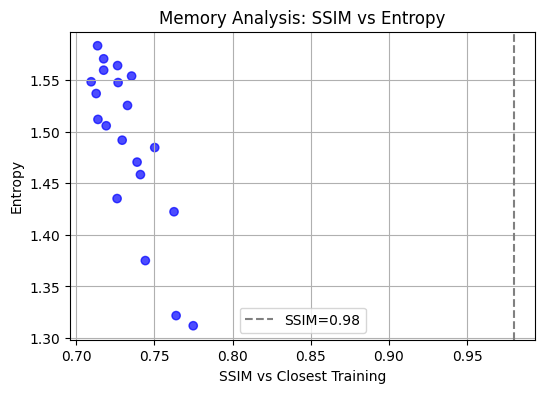

In [ ]:
# Plot SSIM vs Entropy
plt.figure(figsize=(6,4))
colors = ['red' if l=='memorized' else 'blue' for l in labels]
plt.scatter(ssim_scores, entropies, c=colors, alpha=0.7)
plt.axvline(0.98, color='gray', linestyle='--', label='SSIM=0.98')
plt.xlabel('SSIM vs Closest Training')
plt.ylabel('Entropy')
plt.title('Memory Analysis: SSIM vs Entropy')
plt.legend()
plt.grid(True)
plt.show()

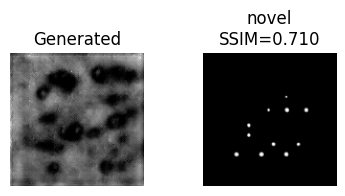

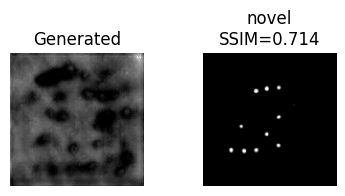

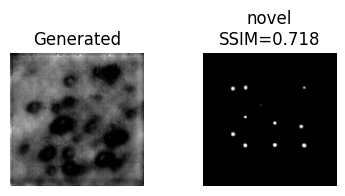

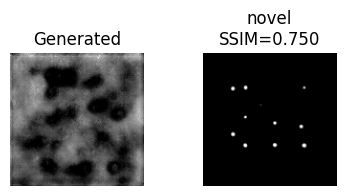

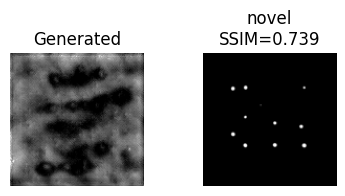

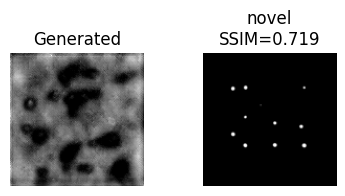

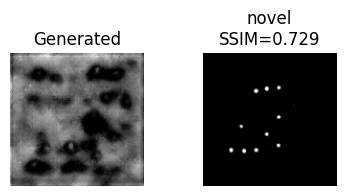

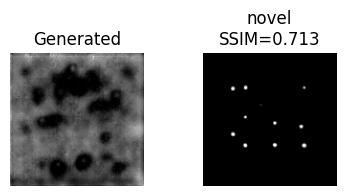

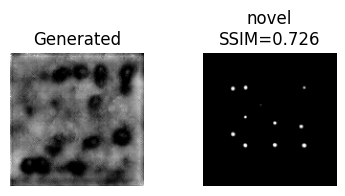

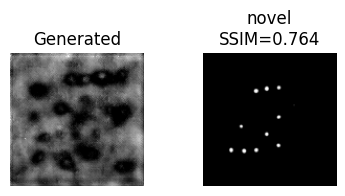

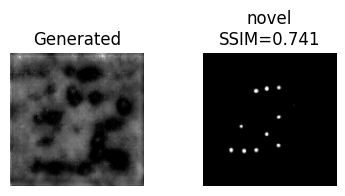

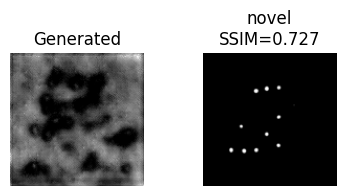

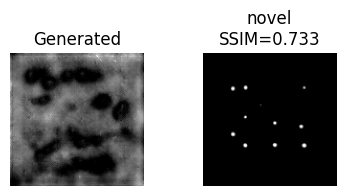

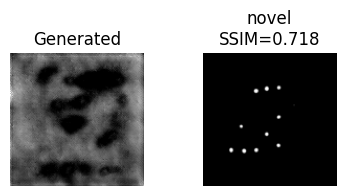

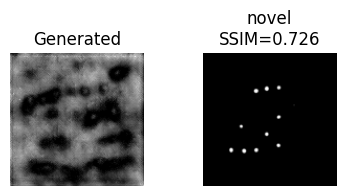

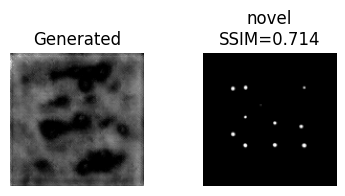

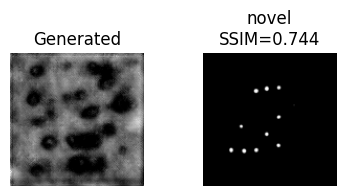

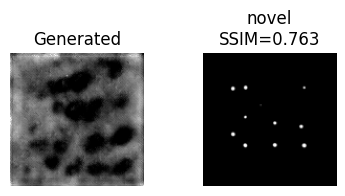

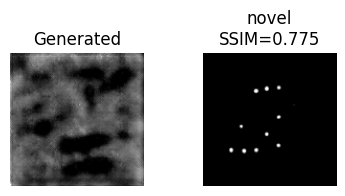

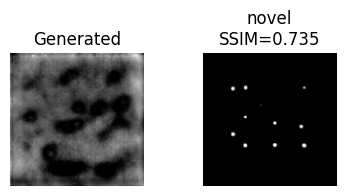

In [ ]:
# Visualize pairs (first 20)
def show_pair(gen, match, score, label):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(4,2))
    ax1.imshow(preprocess_image(gen), cmap='gray')
    ax1.set_title('Generated')
    ax2.imshow(match, cmap='gray')
    ax2.set_title(f"{label}\nSSIM={score:.3f}")
    for ax in (ax1, ax2): ax.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ 顯示最多 20 組
for i in range(min(20, len(generated_images))):
    show_pair(generated_images[i], matches[i], ssim_scores[i], labels[i])


In [ ]:
for i, gen in enumerate(generated_images):
    g = preprocess_image(gen)
    scores = []
    for tr in train_images:
        t = preprocess_image(tr)
        s = ssim(g, t, data_range=1.0)
        scores.append(s)
    top_scores = sorted(scores, reverse=True)[:3]
    print(f"Sample {i+1} top SSIMs: {top_scores}")


Sample 1 top SSIMs: [np.float64(0.7095329429705866), np.float64(0.7074271247769371), np.float64(0.7072425131942555)]
Sample 2 top SSIMs: [np.float64(0.7136394554589874), np.float64(0.7092518683369621), np.float64(0.7077005703235892)]
Sample 3 top SSIMs: [np.float64(0.7175333269495958), np.float64(0.7170940880485245), np.float64(0.7159996089645319)]
Sample 4 top SSIMs: [np.float64(0.7501948463929179), np.float64(0.7493950080248981), np.float64(0.7449312223979534)]
Sample 5 top SSIMs: [np.float64(0.738916576900072), np.float64(0.7359684033688707), np.float64(0.7311975195908834)]
Sample 6 top SSIMs: [np.float64(0.719165197163476), np.float64(0.7174850448213487), np.float64(0.7156827392782811)]
Sample 7 top SSIMs: [np.float64(0.7293721589228024), np.float64(0.7284009517172402), np.float64(0.7264600000531478)]
Sample 8 top SSIMs: [np.float64(0.7127489673799574), np.float64(0.710335655804474), np.float64(0.7087870590020376)]
Sample 9 top SSIMs: [np.float64(0.726121790669331), np.float64(0.72

In [ ]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def show_top_k_matches(generated_images, train_images, k=3):
    for idx, gen in enumerate(generated_images):
        g = preprocess_image(gen)
        scores = []
        for i, tr in enumerate(train_images):
            t = preprocess_image(tr)
            score = ssim(g, t, data_range=1.0)
            scores.append((score, i, tr))

        top_k = sorted(scores, reverse=True)[:k]

        # 畫圖
        fig, axs = plt.subplots(1, k + 1, figsize=(4 + k*2, 2))
        axs[0].imshow(g, cmap='gray')
        axs[0].set_title("Generated")
        axs[0].axis("off")

        for j, (s, i, img) in enumerate(top_k):
            axs[j+1].imshow(img, cmap='gray')
            axs[j+1].set_title(f"Top {j+1}\nSSIM={s:.3f}")
            axs[j+1].axis("off")

        plt.suptitle(f"Sample {idx+1}: Generated vs Top-{k} Matches")
        plt.tight_layout()
        plt.show()


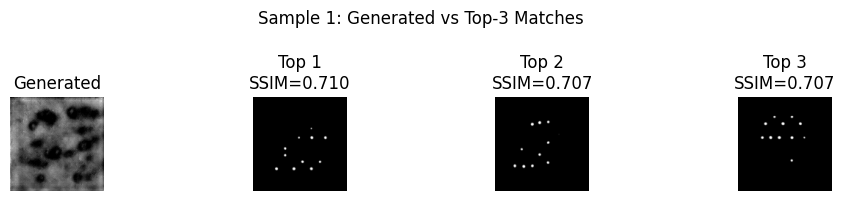

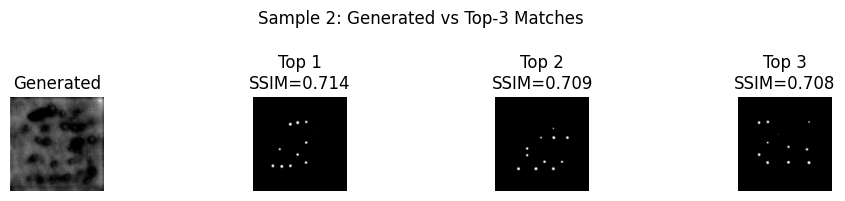

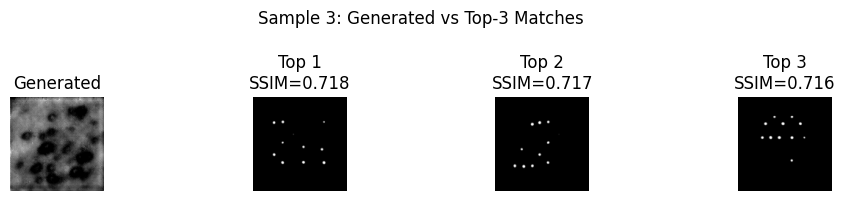

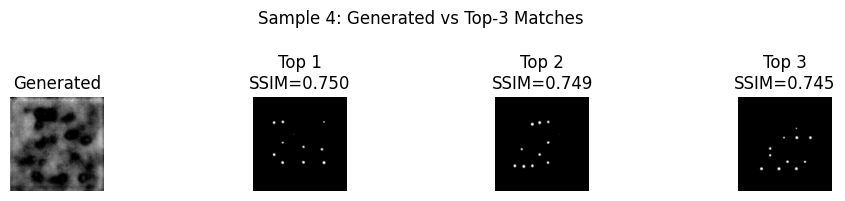

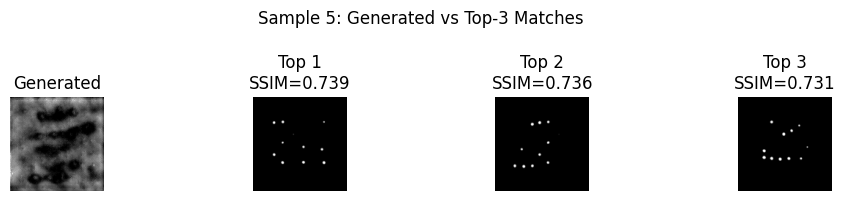

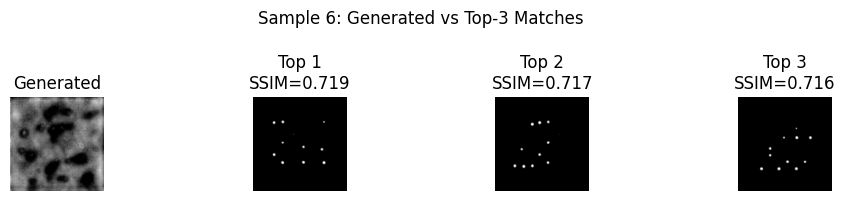

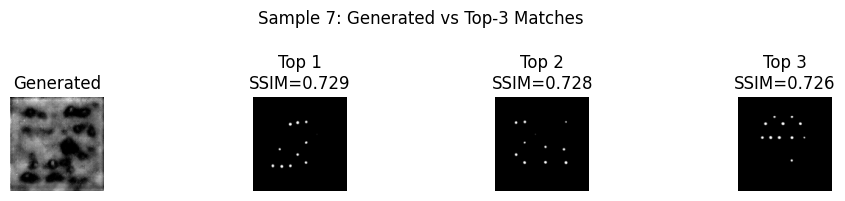

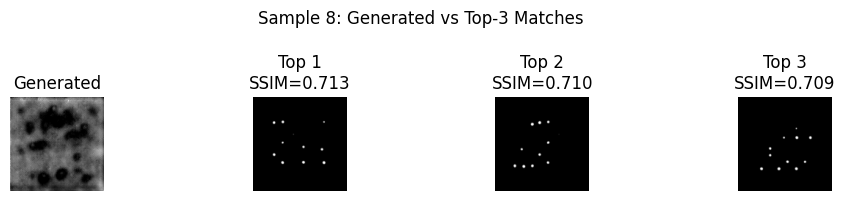

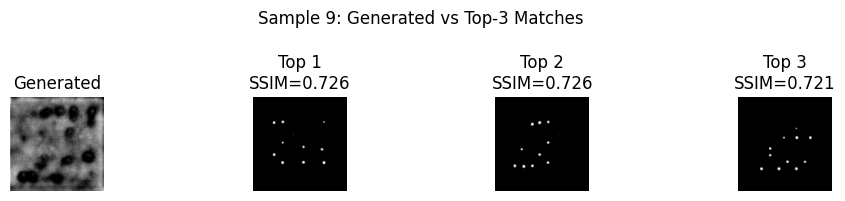

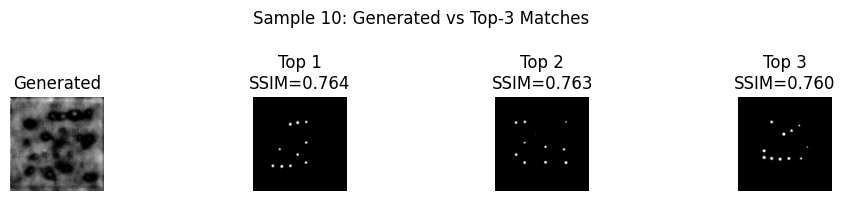

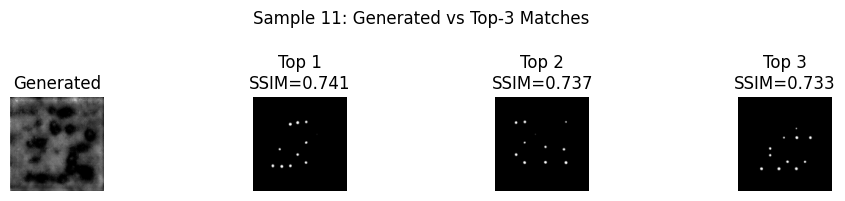

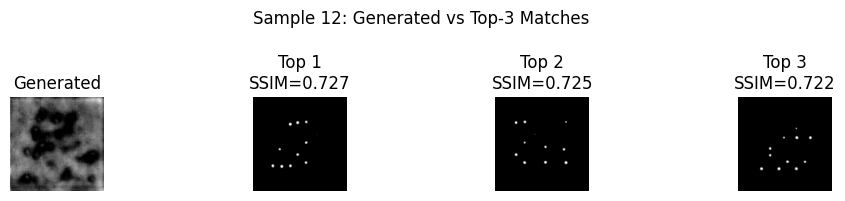

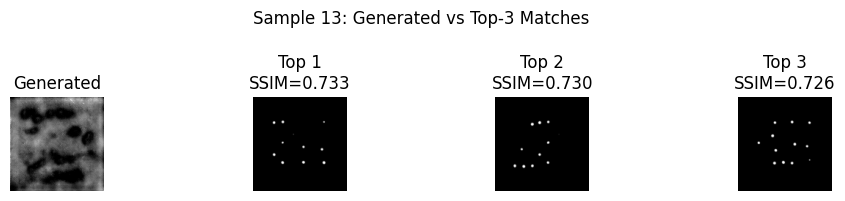

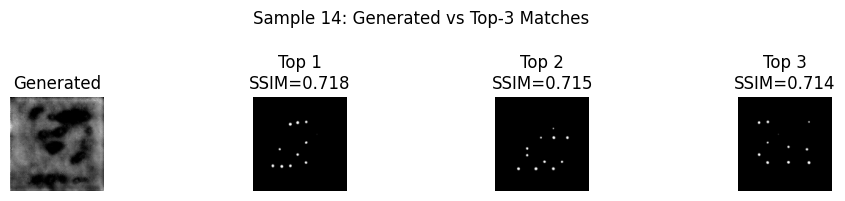

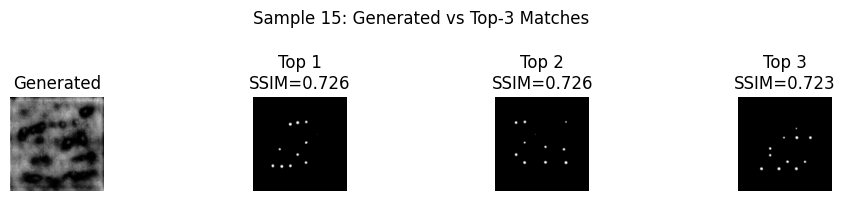

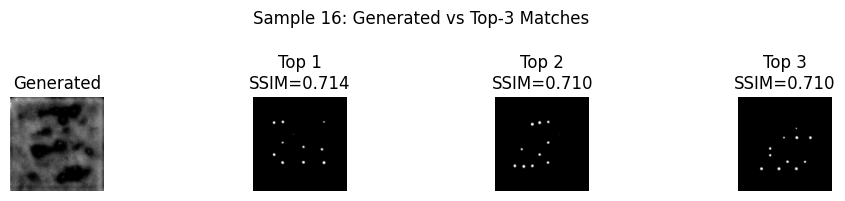

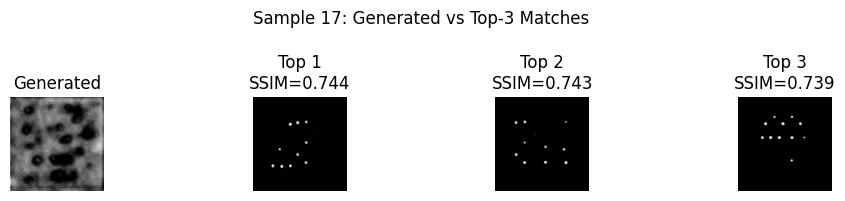

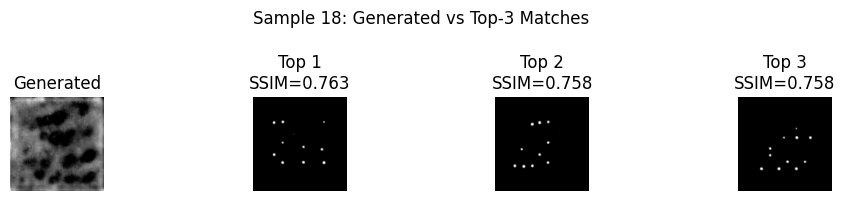

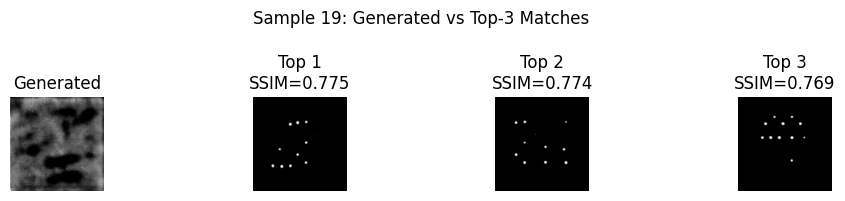

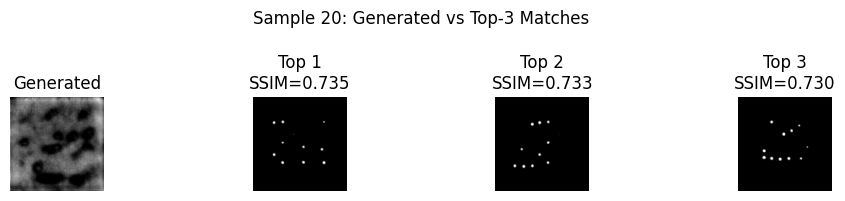

In [ ]:
show_top_k_matches(generated_images, train_images, k=3)


In [ ]:
# ✅ Mutual Information Function
def compute_mutual_info(img1, img2, bins=64):
    h1 = np.histogram(img1.flatten(), bins=bins, range=(0,1))[0]
    h2 = np.histogram(img2.flatten(), bins=bins, range=(0,1))[0]
    joint_hist, _, _ = np.histogram2d(img1.flatten(), img2.flatten(), bins=bins, range=[[0,1],[0,1]])
    pxy = joint_hist / np.sum(joint_hist)
    px = h1 / np.sum(h1)
    py = h2 / np.sum(h2)
    pxpy = np.outer(px, py)
    pxy_flat = pxy.flatten()
    pxpy_flat = pxpy.flatten()
    nz = pxy_flat > 0
    mi = np.sum(pxy_flat[nz] * np.log(pxy_flat[nz] / pxpy_flat[nz]))
    return mi


In [ ]:
# ✅ 計算每對 Generated 與 Matched 圖片的 Mutual Information
mi_scores = []
for gen, match in zip(generated_images, matches):
    g = preprocess_image(gen)     # 生成圖處理過後
    t = preprocess_image(match)   # 配對訓練圖處理過後
    mi = compute_mutual_info(g, t)
    mi_scores.append(mi)


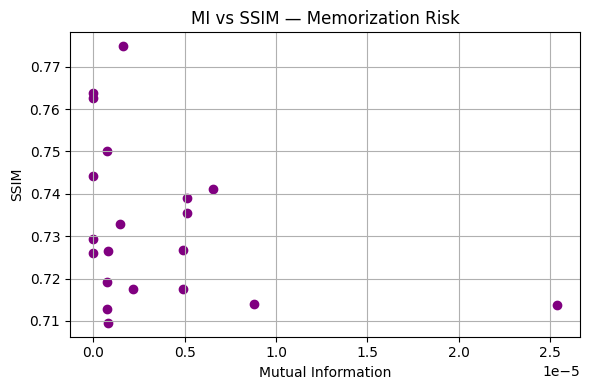

In [ ]:
# ✅ 畫出 MI vs SSIM 圖
plt.figure(figsize=(6,4))
plt.scatter(mi_scores, ssim_scores, c='purple')
plt.xlabel("Mutual Information")
plt.ylabel("SSIM")
plt.title("MI vs SSIM — Memorization Risk")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-20-2075217690>:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([ssim_rare, ssim_common], labels=["Rare", "Common"])
<ipython-input-20-2075217690>:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([mi_rare, mi_common], labels=["Rare", "Common"])


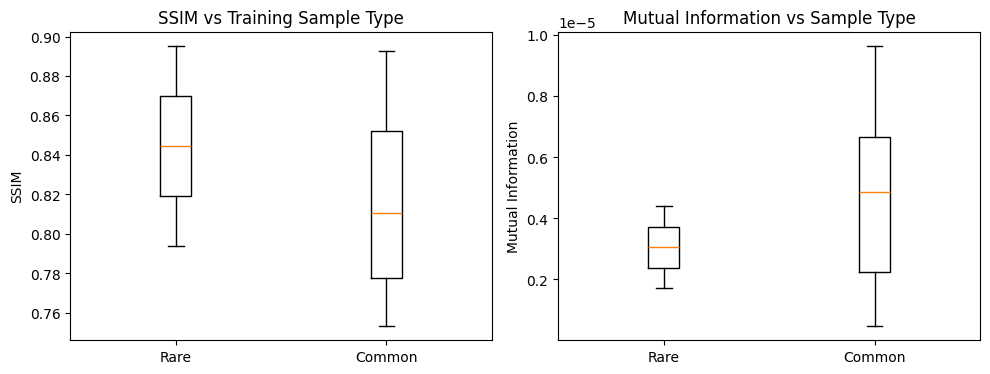

In [ ]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# 假設已有的資料：
# ssim_scores: SSIM 分數（每張 generated image）
# mi_scores: Mutual Information 分數（每張 generated image）
# matched_indices: 對應到的 training image index
# 這裡先模擬 matched_indices 與 rare_idx_set 供後續比較分析

# 生成範例資料（實際請替換為真實對應關係）
np.random.seed(42)
ssim_scores = np.random.uniform(0.75, 0.90, size=20)
mi_scores = np.random.uniform(0.0, 1e-5, size=20)
matched_indices = np.random.randint(0, 1000, size=20)

# 假設：training set 中有 50 張為 rare 類別（模擬資料集統計結果）
rare_idx_set = set(np.random.choice(range(1000), size=50, replace=False))

# 根據 matched training image 是不是 rare 來分組
ssim_rare = [ssim_scores[i] for i in range(len(ssim_scores)) if matched_indices[i] in rare_idx_set]
ssim_common = [ssim_scores[i] for i in range(len(ssim_scores)) if matched_indices[i] not in rare_idx_set]
mi_rare = [mi_scores[i] for i in range(len(mi_scores)) if matched_indices[i] in rare_idx_set]
mi_common = [mi_scores[i] for i in range(len(mi_scores)) if matched_indices[i] not in rare_idx_set]

# 繪製 boxplot 比較記憶率指標
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].boxplot([ssim_rare, ssim_common], labels=["Rare", "Common"])
axes[0].set_title("SSIM vs Training Sample Type")
axes[0].set_ylabel("SSIM")

axes[1].boxplot([mi_rare, mi_common], labels=["Rare", "Common"])
axes[1].set_title("Mutual Information vs Sample Type")
axes[1].set_ylabel("Mutual Information")

plt.tight_layout()
plt.show()


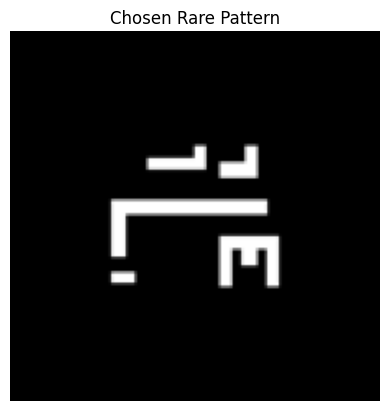

Sample 1: SSIM vs rare pattern = 0.6409
Sample 2: SSIM vs rare pattern = 0.6356
Sample 3: SSIM vs rare pattern = 0.6379
Sample 4: SSIM vs rare pattern = 0.6697
Sample 5: SSIM vs rare pattern = 0.6585
Sample 6: SSIM vs rare pattern = 0.6420
Sample 7: SSIM vs rare pattern = 0.6535
Sample 8: SSIM vs rare pattern = 0.6356
Sample 9: SSIM vs rare pattern = 0.6524
Sample 10: SSIM vs rare pattern = 0.6882
Sample 11: SSIM vs rare pattern = 0.6578
Sample 12: SSIM vs rare pattern = 0.6414
Sample 13: SSIM vs rare pattern = 0.6654
Sample 14: SSIM vs rare pattern = 0.6381
Sample 15: SSIM vs rare pattern = 0.6499
Sample 16: SSIM vs rare pattern = 0.6359
Sample 17: SSIM vs rare pattern = 0.6645
Sample 18: SSIM vs rare pattern = 0.6804
Sample 19: SSIM vs rare pattern = 0.6986
Sample 20: SSIM vs rare pattern = 0.6582


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ✅ 替換為你想比較的 rare pattern 圖片路徑
your_rare_path = "/content/drive/MyDrive/Litho_dataset/Contact/rare/cell9968.png"

# ✅ 載入並轉為灰階 & NumPy 格式
rare_img = Image.open(your_rare_path).convert("L")
rare_np = np.array(rare_img.resize((128, 128))) / 255.0

# ✅ 顯示 rare pattern 圖片
plt.imshow(rare_np, cmap='gray')
plt.title("Chosen Rare Pattern")
plt.axis("off")
plt.show()

# ✅ 與生成圖像做 SSIM 比較（逐一列印）
for i, gen in enumerate(generated_images):
    gen_np = preprocess_image(gen, (128, 128))
    score = ssim(gen_np, rare_np, data_range=1.0)
    print(f"Sample {i+1}: SSIM vs rare pattern = {score:.4f}")


In [ ]:
rare_img_path = "/content/data/printed/rare_special.png"
